## ANN approach for ARM


In [1]:
"""
@author: Dr. H K Patel, Pankaj, Aditya
"""
import time
start = time.time()
from sklearn.decomposition import NMF
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import warnings
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20','21','22',
        '23','24','25','26','27','28','29','30','31','32']

df = pd.read_csv("groceries.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
df.head(5)

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,citrus fruit,semi-finished bread,margarine,ready soups,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,tropical fruit,yogurt,coffee,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,whole milk,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,pip fruit,yogurt,cream cheese,meat spreads,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,other vegetables,whole milk,condensed milk,long life bakery product,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [3]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
count,9835,7676,6033,4734,3729,2874,2229,1684,1246,896,...,14,8,7,7,6,5,4,1,1,1
unique,158,151,155,153,150,137,138,140,128,120,...,13,7,6,7,5,4,3,1,1,1
top,sausage,whole milk,whole milk,whole milk,rolls/buns,soda,soda,shopping bags,soda,shopping bags,...,waffles,bottled beer,chocolate,long life bakery product,hygiene articles,napkins,house keeping products,skin care,hygiene articles,candles
freq,825,654,506,315,176,150,120,76,61,49,...,2,2,2,1,2,2,2,1,1,1


In [4]:
df.shape

(9835, 32)

In [5]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

In [6]:
def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items


In [7]:
def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

In [8]:
unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))


n = 15
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})


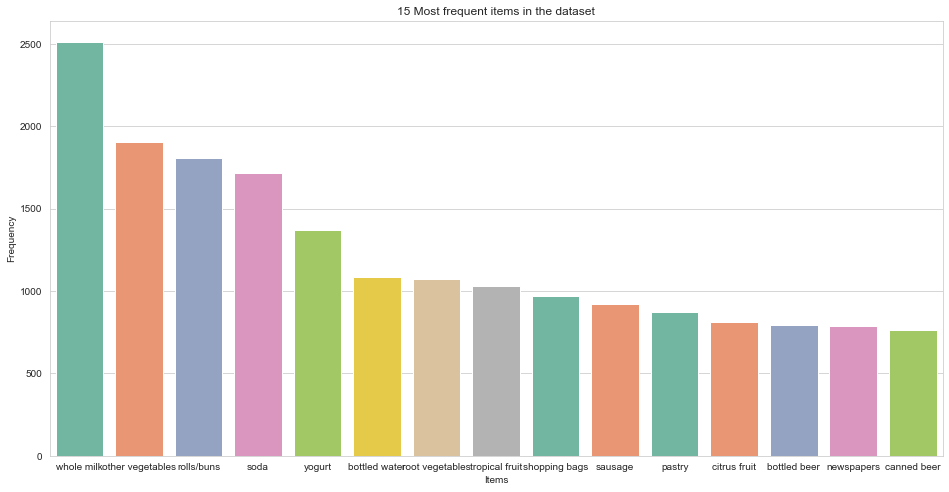

In [9]:
fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

In [10]:
train_test_split = np.random.rand(len(onehot_items)) < 0.80
train_x = onehot_items[train_test_split]
test_x = onehot_items[~train_test_split]
print()


In [11]:
train_validation_split = np.random.rand(len(train_x)) < 0.80
validation_x = train_x[~train_validation_split]
train_x = train_x[train_validation_split]

In [12]:
def weight_variable(weight_name, weight_shape):
    return tf.get_variable(name = "weight_" + weight_name,shape = weight_shape, 
            initializer = tf.contrib.layers.xavier_initializer()) 

In [13]:
def bias_variable(bias_shape):
    initial = tf.constant(0.1, shape = bias_shape)
    return tf.Variable(initial)

In [14]:
def encoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,e_weights_h1),e_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,e_weights_h2),e_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,e_weights_h3),e_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,e_weights_h4),e_biases_h4))
    return l4

In [15]:
def decoder(x):
    l1 = tf.nn.softsign(tf.add(tf.matmul(x,d_weights_h1),d_biases_h1))
    l2 = tf.nn.softsign(tf.add(tf.matmul(l1,d_weights_h2),d_biases_h2))
    l3 = tf.nn.softsign(tf.add(tf.matmul(l2,d_weights_h3),d_biases_h3))
    l4 = tf.nn.sigmoid(tf.add(tf.matmul(l3,d_weights_h4),d_biases_h4))
    return l4

#### Terminology

input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.00002
keep_prob = 0.6
l2_reg_rate = 0.00001


In [16]:
input_dim = 169

n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 32
n_hidden_4 = 16

training_epochs = 30
batch_size = 50
total_batches = (train_x.shape[0] // batch_size)

learning_rate = 0.0002 #0.0002
keep_prob = 0.8
l2_reg_rate = 0.000001

In [17]:
tf.reset_default_graph()

In [18]:
is_training = tf.placeholder_with_default(False, shape = ())
X = tf.placeholder(tf.float32, shape=[None,input_dim])
X_drop = tf.contrib.layers.dropout(X, keep_prob, is_training = is_training)
#X_drop = tf.contrib.layers.dropout(X, keep_prob, noise_shape=None, is_training=True, outputs_collections=None, scope=None, seed=None )
print("X_drop", X_drop)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
X_drop Tensor("Dropout/cond/Merge:0", shape=(?, 169), dtype=float32)


##### --------------------- Encoder Variables --------------- ####

In [19]:
e_weights_h1 = weight_variable("el1",[input_dim, n_hidden_1])
e_biases_h1 = bias_variable([n_hidden_1])

e_weights_h2 = weight_variable("el2",[n_hidden_1, n_hidden_2])
e_biases_h2 = bias_variable([n_hidden_2])

e_weights_h3 = weight_variable("el3",[n_hidden_2, n_hidden_3])
e_biases_h3 = bias_variable([n_hidden_3])

e_weights_h4 = weight_variable("el4",[n_hidden_3, n_hidden_4])
e_biases_h4 = bias_variable([n_hidden_4])
e_biases_h4

<tf.Variable 'Variable_3:0' shape=(16,) dtype=float32_ref>



#### --------------------- Decoder Variables --------------- ####

In [20]:
d_weights_h1 = weight_variable("dl1",[n_hidden_4, n_hidden_3])
d_biases_h1 = bias_variable([n_hidden_3])

d_weights_h2 = weight_variable("dl2",[n_hidden_3, n_hidden_2])
d_biases_h2 = bias_variable([n_hidden_2])

d_weights_h3 = weight_variable("dl3",[n_hidden_2, n_hidden_1])
d_biases_h3 = bias_variable([n_hidden_1])

d_weights_h4 = weight_variable("dl4",[n_hidden_1, input_dim])
d_biases_h4 = bias_variable([input_dim])

In [21]:
encoded = encoder(X_drop)
print("HHHH==",encoded)
decoded = decoder(encoded)
print("MMMM==", decoded) 

HHHH== Tensor("Sigmoid:0", shape=(?, 16), dtype=float32)
MMMM== Tensor("Sigmoid_1:0", shape=(?, 169), dtype=float32)


In [22]:
regularizer = tf.contrib.layers.l2_regularizer(l2_reg_rate)
reg_loss = regularizer(e_weights_h1) + regularizer(e_weights_h2) + regularizer(e_weights_h3) + regularizer(e_weights_h4) 
cost_function = -tf.reduce_mean(((X * tf.log(decoded)) + ((1 - X) * tf.log(1 - decoded)))) + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function)

In [23]:
with tf.Session() as session:
    Tr_loss=[]
    Val_loss=[]
    tf.global_variables_initializer().run()
    print("Epoch","  ","Tr. Loss"," ","Val. Loss")
    for epoch in range(training_epochs):
        for b in range(total_batches):
            offset = (b * batch_size) % (train_x.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :] 
            _, c = session.run([optimizer, cost_function],feed_dict={X: batch_x, is_training: True})
    
        tr_c = session.run(cost_function,feed_dict={X: train_x, is_training: False})
        val_c = session.run(cost_function,feed_dict={X: validation_x, is_training: False})
        print(epoch+1,"\t",tr_c," ",val_c)
        Tr_loss.append(tr_c)
        Val_loss.append(val_c)
    
    tr_p = session.run(decoded,feed_dict={X: train_x, is_training: False})
    roc_auc = roc_auc_score(train_x,tr_p,average = "samples")
    print("Training ROC AUC: ", round(roc_auc,4))

    val_p = session.run(decoded,feed_dict={X: validation_x, is_training: False})
    roc_auc = roc_auc_score(validation_x,val_p,average = "samples")
    print("Validation ROC AUC: ", round(roc_auc,4))
    
    ts_p = session.run(decoded,feed_dict={X: test_x, is_training: False})
    roc_auc = roc_auc_score(test_x,ts_p,average = "samples")
    print("Test ROC AUC: ", round(roc_auc,4),"\n")
    
    item_preds = session.run(decoded,feed_dict={X: test_x.reshape(-1,169), is_training: False})
    print("ttt==",len(item_preds))
    item_preds[item_preds >= 0.05] = 1
    item_preds[item_preds < 0.05] = 0
    

Epoch    Tr. Loss   Val. Loss
1 	 0.23586462   0.23589796
2 	 0.1200995   0.12016546
3 	 0.10767347   0.10771217
4 	 0.10442512   0.10443811
5 	 0.10318437   0.103178345
6 	 0.10260663   0.10258722
7 	 0.10230211   0.102274284
8 	 0.102126725   0.102094606
9 	 0.10201847   0.101984985
10 	 0.10194763   0.10191464
11 	 0.1018987   0.101867184
12 	 0.10186282   0.10183318
13 	 0.10183328   0.101805426
14 	 0.101789705   0.10176126
15 	 0.098029956   0.097966835
16 	 0.09648762   0.096387655
17 	 0.09587297   0.09575672
18 	 0.095449544   0.095313035
19 	 0.09510415   0.09495674
20 	 0.09484815   0.094680354
21 	 0.09463584   0.094457395
22 	 0.09446792   0.09428465
23 	 0.0943248   0.094134204
24 	 0.094196856   0.09400211
25 	 0.094087526   0.0938892
26 	 0.09394265   0.093738854
27 	 0.093828835   0.09362377
28 	 0.09369221   0.093487225
29 	 0.09355776   0.09334861
30 	 0.09340213   0.09319163
Training ROC AUC:  0.8366
Validation ROC AUC:  0.8417
Test ROC AUC:  0.8354 

ttt== 1986


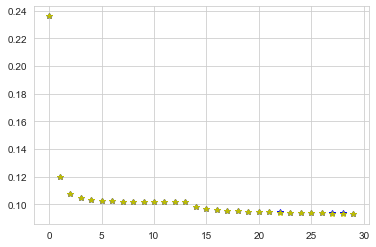

In [24]:
plt.plot(Tr_loss,'b*', Val_loss, 'y*')
plt.show()

In [25]:
"""   
i = 100
#print("Items in basket: ",get_items_from_ohe(test_x[i],unique_items))
print("Recommended item(s): ",get_items_from_ohe(item_preds[i],unique_items))
"""
model = NMF(n_components=100, init='random', random_state=0)
transation_w = model.fit_transform(item_preds)
items_h = model.components_

#get_items_from_ohe(items_h[1],unique_items)

print("Frequent item(s): ",get_items_from_ohe(items_h[0],unique_items))

Frequent item(s):  ['beef' 'berries' 'bottled beer' 'bottled water' 'brown bread' 'butter'
 'candy' 'canned beer' 'chewing gum' 'chicken' 'chocolate' 'citrus fruit'
 'coffee' 'cream cheese ' 'curd' 'dessert' 'domestic eggs' 'frankfurter'
 'frozen vegetables' 'fruit/vegetable juice' 'hamburger meat'
 'hard cheese' 'hygiene articles' 'long life bakery product' 'margarine'
 'meat' 'misc. beverages' 'napkins' 'newspapers' 'onions'
 'other vegetables' 'pastry' 'pip fruit' 'pork' 'red/blush wine'
 'rolls/buns' 'root vegetables' 'salty snack' 'sausage'
 'semi-finished bread' 'shopping bags' 'soda' 'specialty chocolate'
 'sugar' 'tropical fruit' 'waffles' 'whipped/sour cream' 'white bread'
 'whole milk' 'yogurt']


In [26]:
total_transection=9835
for i in range(100):
    xx=np.asarray(np.nonzero(items_h[i]))
    [m,n]=(np.asarray(np.nonzero(items_h[i]))).shape
    support_A_B=len(np.intersect1d(np.nonzero(onehot_items[:,xx[0,n-1]]),np.nonzero(onehot_items[:,xx[0,n-2]])))/total_transection
    #print("{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}")
    [xxxx,sup_A]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-1]]))).shape
    [xxxx,sup_B]=(np.asarray(np.nonzero(onehot_items[:,xx[0,n-2]]))).shape
    support_A=sup_A/total_transection
    support_B=sup_B/total_transection
    confidence_A_B=support_A_B / (support_A)
    confidence_B_A=support_A_B / (support_B)
    #lift and conviction
    lift_A_B=confidence_A_B / support_B
    conviction_A_B=(1-support_B)/(1-confidence_A_B)
    print(i+1, "{" + str(unique_items[xx[0,n-1]]) + "}" +"=>" "{" + str(unique_items[xx[0,n-2]]) + "}"+" "+ "support="+ str(round(support_A_B,2)) +" "+ "confidence=" + str(round(confidence_A_B,2))  +" "+ "lift=" + str(round(lift_A_B,2))  +" "+ "conviction=" + str(round(conviction_A_B,2)) )


1 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
2 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
3 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
4 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
5 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
6 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
7 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
8 {zwieback}=>{yogurt} support=0.0 confidence=0.21 lift=1.48 conviction=1.08
9 {yogurt}=>{whole milk} support=0.06 confidence=0.4 lift=1.57 conviction=1.24
10 {yogurt}=>{white bread} support=0.01 confidence=0.06 lift=1.54 conviction=1.02
11 {yogurt}=>{soda} support=0.03 confidence=0.2 lift=1.12 conviction=1.03
12 {tropical fruit}=>{soft cheese} support=0.0 confidence=0.03 lift=1.82 conviction=1.01
13 {yogurt}=>{tropical fruit} support=0.03 con

In [27]:
end = time.time()
print("Time consumed in working: ",end - start)

Time consumed in working:  82.29786086082458


# Under Progress

In [28]:
#antecedents=[]
#consequents=[]
antecedents=str(unique_items[xx[0,n-1]])
consequents=str(unique_items[xx[0,n-2]])

temp = pd.DataFrame({'Support': str(round(support_A_B,2)), 'Confidence': str(round(confidence_A_B,2)), 'Lift': str(round(lift_A_B,2)), 'Conviction':str(round(conviction_A_B,2)) })
    result_ann = pd.concat([result_ann, temp])

result_ann.to_csv("result_ann.csv", sep=',') 

IndentationError: unexpected indent (<ipython-input-28-24ff34a3f6b2>, line 7)

In [ ]:
temp = {'Support': str(round(support_A_B,2)), 'Confidence': str(round(confidence_A_B,2)), 'Lift': str(round(lift_A_B,2)), 'Conviction':str(round(conviction_A_B,2)) }
dataframe = pd.DataFrame(temp) 
dataframe.to_csv('result_ann.csv')